In [291]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\giuliasilva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [292]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\giuliasilva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [293]:
#importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns
import numpy as np
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

In [294]:
#Criando a classe base para carregar  e formatar os dados
class DataPipeline:
    def __init__(self, file_path, delimiter=';'):
        self.file_path = file_path
        self.delimiter = delimiter
        self.data = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path, delimiter=self.delimiter)
        return self.data

    def preprocess(self):
        self.data['data'] = pd.to_datetime(self.data['data'], format='%d/%m/%Y')
        self.data = self.data[['data', 'valor_da_cotacao']].rename(columns={'data': 'ds', 'valor_da_cotacao': 'y'})
        return self.data


In [295]:
#Criando a classe aonde vou implementar as configurações do modelo, o treinamento e a previsão 
class ProphetPipeline:
    def __init__(self, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False):
        self.model = Prophet(
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality,
            daily_seasonality=daily_seasonality,
            changepoint_prior_scale=0.3,
            seasonality_mode='multiplicative',
            interval_width=0.70
        )
        self.holidays_df = pd.DataFrame()

    #Função para divisão das bases 
    def split_data(self, data, train_end_date, test_start_date):
        """Divide os dados em treino e teste."""
        self.train_data = data[data['ds'] <= train_end_date].copy()
        self.test_data = data[data['ds'] >= test_start_date].copy()
        return self.train_data, self.test_data

    #Função para mapeamento dos eventos como pandemia, guerra  
    def add_event(self, holiday_name, event_dates, lower_window, upper_window):
        """Adiciona eventos históricos à lista de feriados."""
        event_df = pd.DataFrame({
            'holiday': holiday_name,
            'ds': pd.to_datetime(event_dates),
            'lower_window': lower_window,
            'upper_window': upper_window
        })
        self.holidays_df = pd.concat([self.holidays_df, event_df], ignore_index=True)

    def create_holidays_df(self):
        """Remove duplicatas no DataFrame de eventos."""
        self.holidays_df.drop_duplicates(inplace=True)
        return self.holidays_df

    #Adicionando os eventos criados ao atributo feriados do modelo 
    def configure_model(self):
        """Configura o modelo com feriados e sazonalidades personalizadas."""
        if not self.holidays_df.empty:
            self.model.holidays = self.holidays_df
        self.model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
        self.model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    #Treino do modelo 
    def fit_model(self):
        """Treina o modelo Prophet com os dados de treino."""
        if not self.holidays_df.empty:
            self.train_data['holiday'] = self.train_data['ds'].isin(self.holidays_df['ds']).astype(int)
        self.model.fit(self.train_data)

    #Previsões do modelo 
    def predict(self, periods=None):
        """Realiza a previsão para os próximos períodos com base no teste."""
        if periods is None:
            periods = len(self.test_data)
        future = self.model.make_future_dataframe(periods=periods, freq='D')
        if not self.holidays_df.empty:
            future['holiday'] = future['ds'].isin(self.holidays_df['ds']).astype(int)
        forecast = self.model.predict(future)
        return forecast



In [296]:
#Esta classe é para tentar consolidar os modelos gráficos que pretendo criar 
class Visualization:
    @staticmethod
    def plot_multiple_lines(data_list, x_col, y_col, labels, colors, title='Gráfico de Linha', xlabel='Data', ylabel='Valor'):
        """Gráfico de linha para múltiplos conjuntos."""
        plt.figure(figsize=(12, 6))
        for data, label, color in zip(data_list, labels, colors):
            plt.plot(data[x_col], data[y_col], label=label, color=color)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()


In [297]:
#Esta classe é por onde eu irei validar a performance do Modelo 
class ModelEvaluation:
    def __init__(self, test_data, forecast):
        self.test_data = test_data[['ds', 'y']] 
        self.forecast = forecast[['ds', 'yhat']] 
        self.comparison = self._merge_data() 

    def _merge_data(self):
        return pd.merge(self.test_data, self.forecast, on='ds', how='inner')

    def calculate_mae(self):
        mae = mean_absolute_error(self.comparison['y'], self.comparison['yhat'])
        print(f"Erro Absoluto Médio (MAE): {mae}")
        return mae

    def calculate_rmse(self):
        rmse = np.sqrt(mean_squared_error(self.comparison['y'], self.comparison['yhat']))
        print(f"Erro Quadrático Médio (RMSE): {rmse}")
        return rmse

    def calculate_mape(self):
        mape = np.mean(np.abs((self.comparison['y'] - self.comparison['yhat']) / self.comparison['y'])) * 100
        print(f"Erro Absoluto Percentual Médio (MAPE): {mape:.2f}%")
        return mape


In [298]:
#Chamando o metodo load da classe DataPipeline para passar os parametros de carregamento do arquivo, como eu limitei o delimitador ; na 
#criação da classe, não preciso passar ele aqui de novo 
data_pipeline = DataPipeline(
    file_path='C:\\Users\\giuliasilva\\Desktop\\Estudo\\POS\\TC - Modulo 04\\base_completa.csv'
    )

#é assim que eu chamo a classe, e estancio a função load e preprocess dela, preciso de um DF para receber o resultado 
df = data_pipeline.load_data()
df = data_pipeline.preprocess()

In [299]:
# Aqui vou usar a nova classe, passando os dados de data_train e data_test, isso porque os parametros de sazionalidade eu fixei
prophet_pipeline = ProphetPipeline()
train_data, test_data = prophet_pipeline.split_data(
    data=df, 
    train_end_date='2022-12-31', 
    test_start_date='2023-01-01'
)

In [300]:
# Exibindo a divisão
print(f"Tamanho do treino: {len(train_data)}")
print(f"Tamanho do teste: {len(test_data)}")

Tamanho do treino: 10826
Tamanho do teste: 504


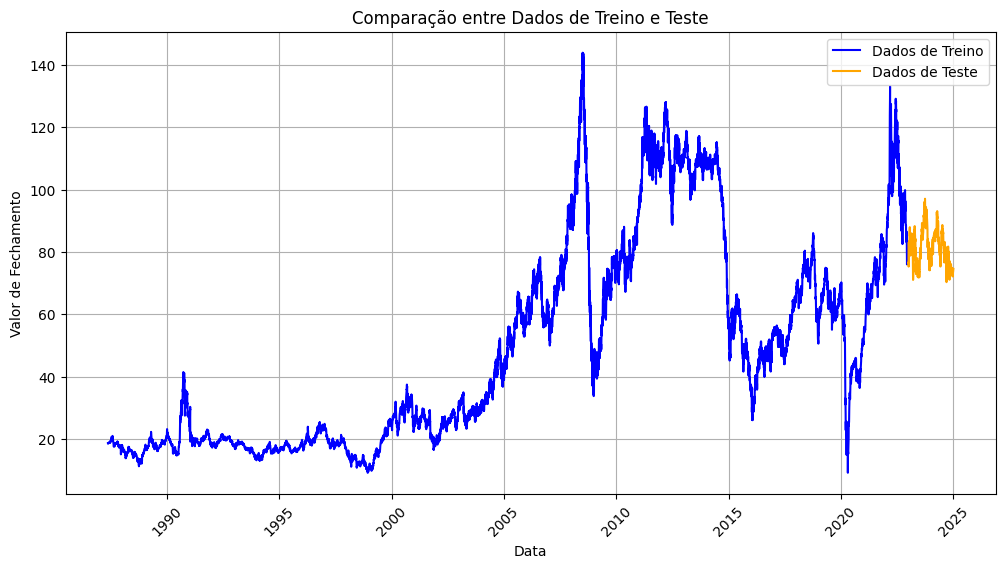

In [301]:
#gerando uma visualização grafica dos dados de treino e teste
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], color='blue', label='Dados de Treino')
plt.plot(test_data['ds'], test_data['y'], color='orange', label='Dados de Teste')

plt.title('Comparação entre Dados de Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [302]:
# Adicionar eventos históricos
prophet_pipeline.add_event('Pandemia COVID-19', ['2020-03-11', '2020-04-01'], -7, 30)
prophet_pipeline.add_event('Guerra Rússia-Ucrânia', ['2022-02-24'], 0, 10)
prophet_pipeline.add_event('Crise Financeira Global 2008', ['2008-09-15'], -10, 10)
prophet_pipeline.add_event('Queda de Preços do Petróleo', ['2014-06-01', '2015-01-01', '2016-01-01'], -30, 30)
prophet_pipeline.add_event('Ataque às instalações da Arábia Saudita', ['2019-09-14'], -1, 2)

# Criar o DataFrame de feriados e eventos
holidays_df = prophet_pipeline.create_holidays_df()


In [303]:
# Configuração do modelo
prophet_pipeline.configure_model()

# Adicionar a coluna 'holiday' a base de treino
prophet_pipeline.train_data['holiday'] = prophet_pipeline.train_data['ds'].apply(
    lambda x: 1 if x in prophet_pipeline.holidays_df['ds'].values else 0
)
prophet_pipeline.fit_model()


07:15:46 - cmdstanpy - INFO - Chain [1] start processing
07:16:09 - cmdstanpy - INFO - Chain [1] done processing


In [304]:
# Garantir que o periodo do forecast seja do mesmo tamanho da base de teste
forecast = prophet_pipeline.predict(periods=len(test_data))

In [305]:
# Exibir os tamanhos para validação
print(f"Tamanho do treino: {len(train_data)}")
print(f"Tamanho do teste: {len(test_data)}")
print(f"Tamanho da previsão: {len(forecast)}")

Tamanho do treino: 10826
Tamanho do teste: 504
Tamanho da previsão: 11330


In [306]:
# Verificar os resultados da previsão
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
11325,2024-05-13,99.525227,81.972890,115.769377
11326,2024-05-14,99.179247,81.279555,114.696685
11327,2024-05-15,98.993318,82.122843,115.440200
11328,2024-05-16,99.117517,82.608991,113.872697
11329,2024-05-17,99.295435,83.293407,115.151356


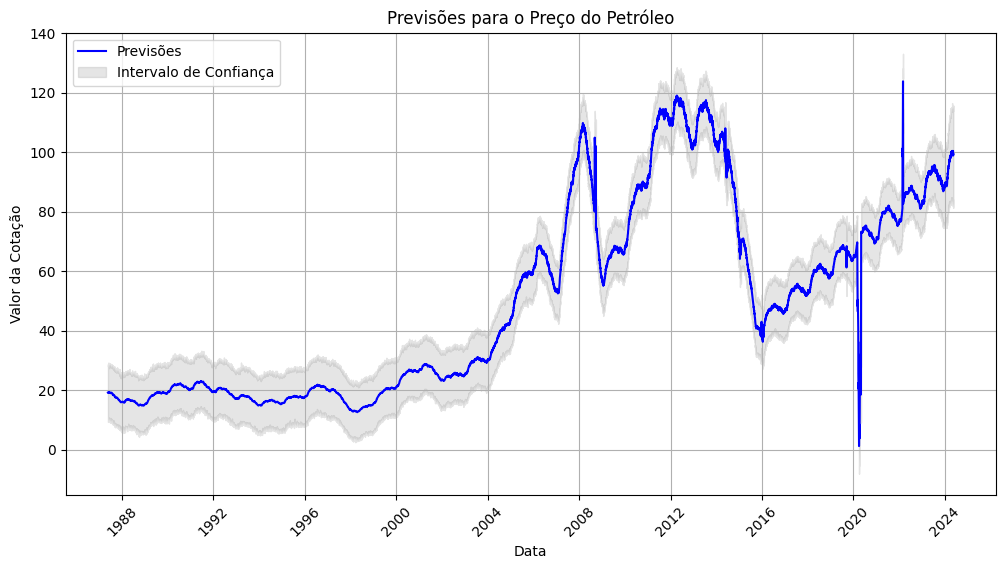

In [307]:
# Criando a lista de dados e configurando os parâmetros
data_list = [forecast]
x_col = 'ds'
y_col = 'yhat'
labels = ['Previsões']
colors = ['blue']

# Criando o gráfico de previsões com intervalo de confiança
plt.figure(figsize=(12, 6))
plt.plot(forecast[x_col], forecast[y_col], label='Previsões', color='blue')
plt.fill_between(forecast[x_col], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Intervalo de Confiança')
plt.title('Previsões para o Preço do Petróleo')
plt.xlabel('Data')
plt.ylabel('Valor da Cotação')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [308]:
#Instanciando a classe de métricas
model_evaluation = ModelEvaluation(test_data, forecast)

# Calculando métricas
mae = model_evaluation.calculate_mae()
rmse = model_evaluation.calculate_rmse()
mape = model_evaluation.calculate_mape()


Erro Absoluto Médio (MAE): 9.297190639063192
Erro Quadrático Médio (RMSE): 10.842968298084333
Erro Absoluto Percentual Médio (MAPE): 11.59%


In [309]:
# Mesclar previsões com dados reais
comparison = pd.merge(test_data, forecast[['ds', 'yhat']], on='ds', how='inner')

# Renomear as colunas para facilitar a interpretação
comparison.rename(columns={'y': 'Real', 'yhat': 'Previsto'}, inplace=True)


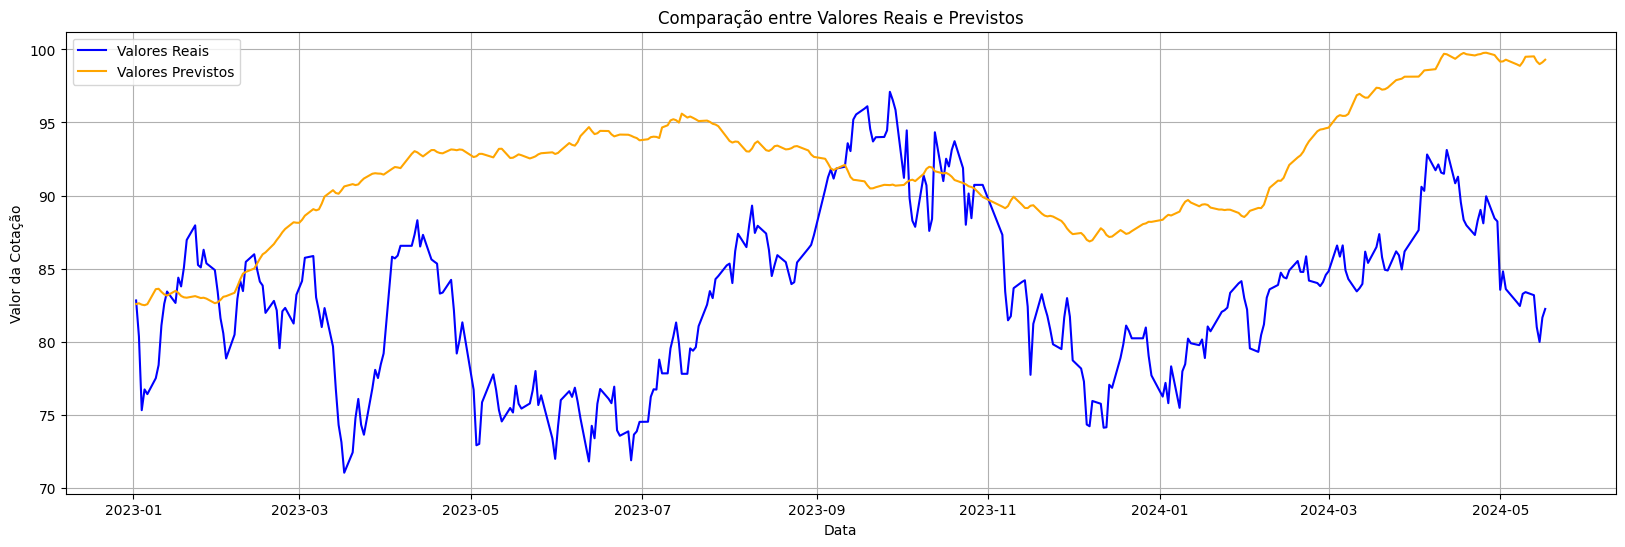

In [310]:
#Plotar dados para comparação da visão real e o previsto para o modelo
plt.figure(figsize=(20, 6))
plt.plot(comparison['ds'], comparison['Real'], label='Valores Reais', color='blue')
plt.plot(comparison['ds'], comparison['Previsto'], label='Valores Previstos', color='orange')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Valor da Cotação')
plt.legend()
plt.grid()
plt.show()


In [311]:
from datetime import datetime

end_date = datetime(2027, 12, 31)

# Calcular o número de dias entre a última data dos dados atuais e o final de 2027
last_date = forecast['ds'].max()
days_until_2027 = (end_date - last_date).days

# Gerar o DataFrame de previsões para o período desejado
future_2025 = prophet_pipeline.model.make_future_dataframe(periods=days_until_2027, freq='D')

In [312]:
# Adicionar os feriados ao DataFrame de previsões
future_2025 = pd.merge(future_2025, holidays_df[['ds', 'holiday']], on='ds', how='left')

# Garantir que a coluna 'holiday' esteja presente nas previsões (0 ou 1)
future_2025['holiday'] = future_2025['ds'].apply(lambda x: 1 if x in holidays_df['ds'].values else 0)

In [313]:
# Gerar as previsões para o período de 2025 até 2027
forecast_2025 = prophet_pipeline.model.predict(future_2025)

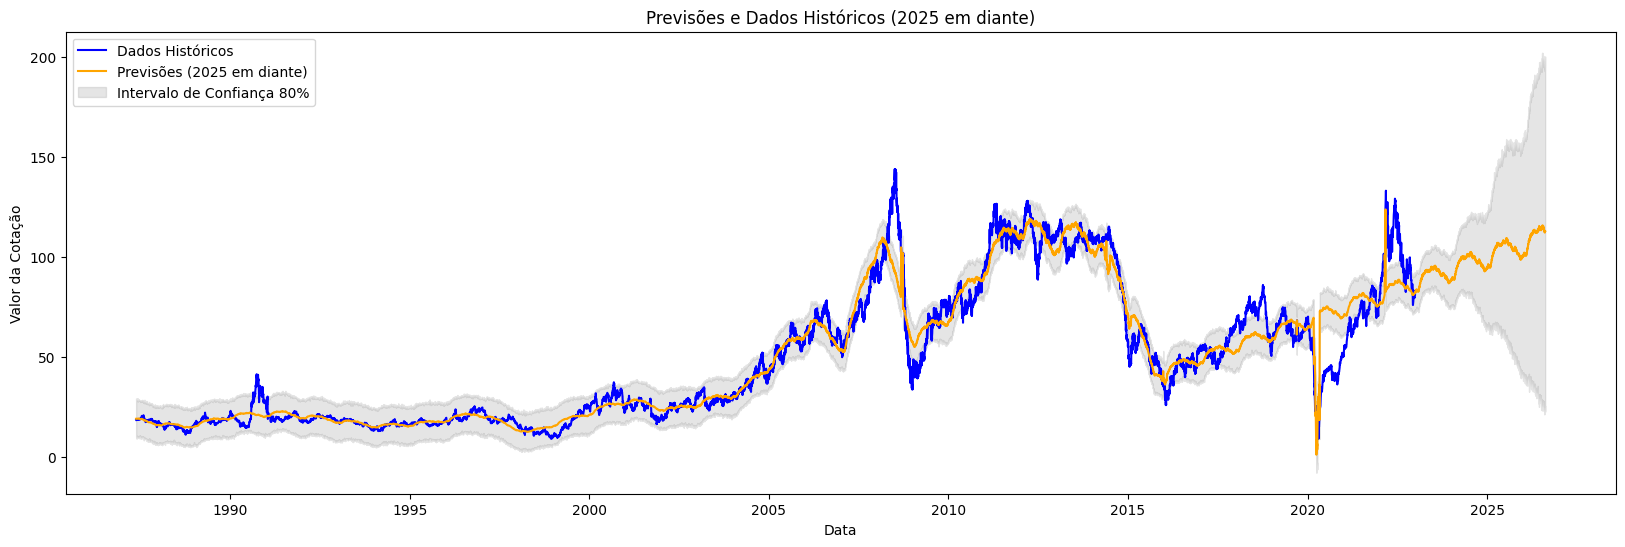

In [314]:
# Visualizando as previsões de 2025 em diante
plt.figure(figsize=(20, 6))

# Dados históricos
plt.plot(train_data['ds'], train_data['y'], label='Dados Históricos', color='blue')

# Previsões feitas pelo modelo
plt.plot(forecast_2025['ds'], forecast_2025['yhat'], label='Previsões (2025 em diante)', color='orange')

# Intervalo de Confiança com 80%
plt.fill_between(forecast_2025['ds'], forecast_2025['yhat_lower'], forecast_2025['yhat_upper'], color='gray', alpha=0.2, label='Intervalo de Confiança 80%')

plt.xlabel('Data')
plt.ylabel('Valor da Cotação')
plt.title('Previsões e Dados Históricos (2025 em diante)')
plt.legend()
plt.show()

In [315]:
forecast_test_period = forecast_2025[forecast_2025['ds'].isin(test_data['ds'])]

#Instanciar a classe de métricas com os dados de teste e as previsões correspondentes
model_evaluation = ModelEvaluation(test_data, forecast_test_period)

#Calcular as métricas
mae = model_evaluation.calculate_mae()
rmse = model_evaluation.calculate_rmse()
mape = model_evaluation.calculate_mape()

Erro Absoluto Médio (MAE): 12.581284053373604
Erro Quadrático Médio (RMSE): 14.379024839482302
Erro Absoluto Percentual Médio (MAPE): 15.98%


In [316]:
import joblib

In [317]:
joblib.dump(Prophet, 'Model_Prophet')

['Model_Prophet']